# 01 Import libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import pandas as pd

In [4]:
# import importlib

## Import our own modules

In [5]:
import lib
# importlib.reload(lib)

In [ ]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.lsp.basis_generator import scaled_shifted_legendre
from lib.lsp.basis_tf_module import Basis_TF_SGD
from lib.lsp.solver_lsp import train_lsp
from lib.lsp.loss_fn_lsp import reg_unif_weighted_logit

#Learning the Solution Path Through SGD
Now, let us run SGD over random $\tilde λ$'s with a linear basis $\Phi(\tilde \lambda)$ of our choice. We want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function is $\min_\beta h(\Phi(\tilde\lambda)\beta, \tilde\lambda) = (1-\tilde\lambda) BCE(X_\text{pass}\Phi(\tilde\lambda)\beta,\ y_\text{pass}) + \tilde\lambda BCE(X_\text{fail}\Phi(\tilde\lambda)\beta,\ y_\text{fail})$. For each batch of training data set, we randomize $\tilde\lambda$.

# 02 Load data

In [7]:
# file path for Colab. May need to change this
X_df = pd.read_csv('X_processed.csv')
y_df = pd.read_csv('y_processed.csv')

In [8]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [9]:
train_X = torch.tensor(X, dtype=torch.float32)
train_y = torch.tensor(y, dtype=torch.float32)

In [10]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

In [11]:
lam_max = [1]
lam_min = [0]
input_dim = X.shape[1]

In [13]:
# Read the CSV file into a DataFrame
truth = pd.read_csv('exact_soln_list_legendre.csv')

# Display the DataFrame
truth

,losses,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,...,theta_36,theta_37,theta_38,theta_39,theta_40,theta_41,theta_42,theta_43,theta_44,theta_45
0,0.190793,-0.373029,0.186622,0.227443,-0.023583,0.164822,0.142992,0.168018,0.026305,0.142661,...,-0.018010,0.054908,-0.005629,0.000000,0.000000,-0.031270,-0.018010,-0.139608,-0.116840,-0.061673
1,0.192130,-0.371212,0.186634,0.227586,-0.023679,0.164875,0.142262,0.167428,0.025960,0.142993,...,-0.017600,0.054199,-0.005657,0.000069,0.000098,-0.031115,-0.017600,-0.139385,-0.116402,-0.061226
2,0.193463,-0.369401,0.186645,0.227729,-0.023775,0.164927,0.141535,0.166842,0.025615,0.143323,...,-0.017191,0.053493,-0.005685,0.000137,0.000195,-0.030961,-0.017191,-0.139162,-0.115965,-0.060781
3,0.194792,-0.367595,0.186656,0.227870,-0.023870,0.164977,0.140811,0.166258,0.025271,0.143653,...,-0.016784,0.052790,-0.005713,0.000205,0.000293,-0.030808,-0.016784,-0.138939,-0.115529,-0.060337
4,0.196117,-0.365794,0.186665,0.228009,-0.023964,0.165027,0.140089,0.165677,0.024927,0.143982,...,-0.016378,0.052089,-0.005741,0.000273,0.000390,-0.030655,-0.016378,-0.138717,-0.115094,-0.059894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.327684,0.692472,-0.029101,-0.033382,-0.017462,-0.005831,-0.225541,-0.146453,-0.051680,0.070009,...,0.105324,-0.201982,0.000913,0.013100,0.018598,0.063129,0.105324,0.157442,0.161747,0.171301
1020,0.325866,0.693930,-0.029932,-0.034521,-0.017548,-0.006565,-0.226194,-0.148351,-0.051246,0.068693,...,0.105340,-0.202186,0.000990,0.013040,0.018537,0.063366,0.105340,0.158131,0.162149,0.171464
1021,0.324032,0.695399,-0.030769,-0.035668,-0.017634,-0.007304,-0.226853,-0.150274,-0.050809,0.067366,...,0.105357,-0.202393,0.001066,0.012980,0.018475,0.063604,0.105357,0.158825,0.162554,0.171627
1022,0.322184,0.696878,-0.031613,-0.036822,-0.017720,-0.008050,-0.227517,-0.152223,-0.050369,0.066028,...,0.105374,-0.202601,0.001143,0.012919,0.018415,0.063843,0.105374,0.159523,0.162962,0.171792


In [14]:
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30', 'theta_31', 'theta_32', 'theta_33', 'theta_34',
                    'theta_35', 'theta_36', 'theta_37', 'theta_38', 'theta_39',
                    'theta_40', 'theta_41', 'theta_42', 'theta_43', 'theta_44',
                    'theta_45']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

# 03 Visualizing convergence of LSP

We use a coefficient profile plot for an arbitrarily selected coefficient (3) to visualize the convergence of our model.

In [15]:
loss_fn = reg_unif_weighted_logit

In [16]:
phi_lam = scaled_shifted_legendre

In [17]:
num_grid = 2**10
lambdas = np.linspace(lam_max[0], lam_min[0], num_grid)

#### Coefficient plot

In [169]:
trace = 50 # run this again before plotting

In [170]:
# build the model
basis_dim = 7
epochs = trace * (2**3)
lr = 0.0625

np.random.seed(8675309)
torch.manual_seed(8675309)
thetas_SGD_history = []
model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
weight = model.linear.weight.clone().detach()
itr = 0
for t in range(epochs):
    grad, weight, itr = train_lsp(itr, weight, GD_data_loader, model, loss_fn,
                                  optimizer, weighted_avg=False, step_size=None,
                                  const=None, distribution='uniform', device=device)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            lam_transformed = 2 * lam - 1
            thetas_SGD.append(model(lam_transformed).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [171]:
trace = 50 # run this again before plotting

In [172]:
coeff_index = 3

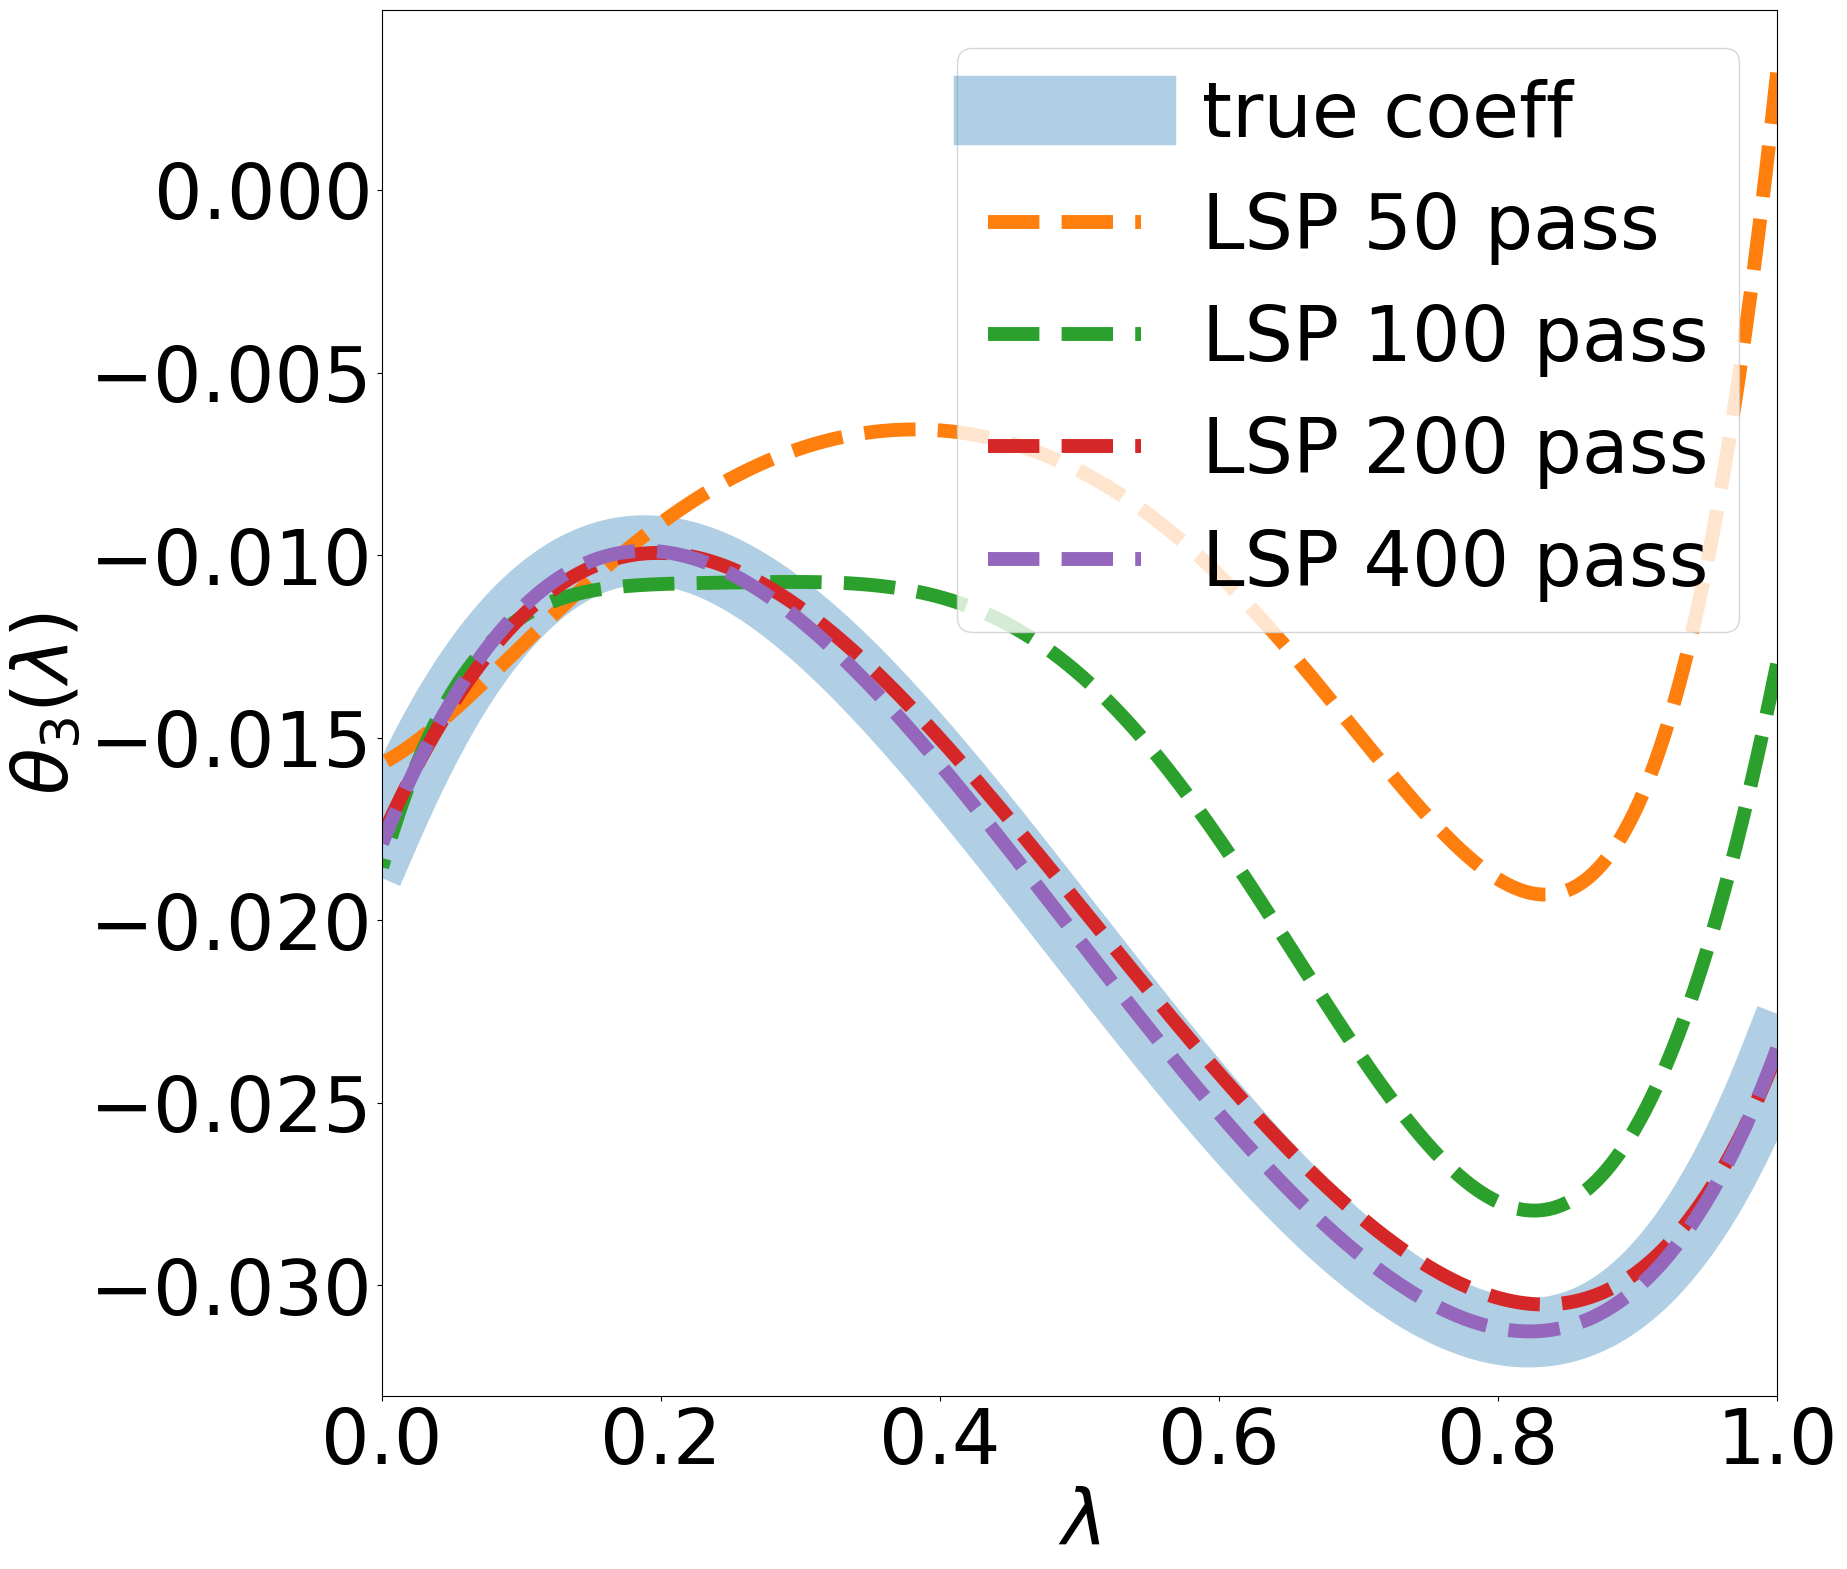

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=50, label=f'true coeff', alpha=0.35)

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=10, label=f'LSP {trace*(2**i)} pass')

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel(f'$\\theta_{coeff_index}(\\lambda)$', fontsize=font_size)

# plt.title('Exact Gradient')
plt.xlim(0, 1)
# plt.ylim(-2, 1)
# Add legend
plt.legend(fontsize=font_size)

# Show the plot
# plt.show()

# save figure
plt.savefig("CPP_exact_3.png")
